 # Neural Network for Multi-Target Prediction

 ## Configuring the package import

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Add parent directory to path if needed
sys.path.append("..")


 ## Loading and Preparing the Dataset

In [9]:
# Load the dataset
# If you have a custom module, uncomment these lines
# from datasets import load_dataset, validate_dataset
# ds = load_dataset("./../data/categorized_v4_numeric.csv")
# ds = validate_dataset(ds)

# Alternative approach using pandas directly
df = pd.read_csv("./../data/categorized_v4_numeric.csv")

# Display the first few rows
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (39775, 110)


,Q1A,Q1E,Q2A,Q2E,Q3A,Q3E,Q4A,Q4E,Q5A,Q5E,...,gender,age,religion,married,familysize,major_category,depression_score,anxiety_score,stress_score,das_score
0,4,3890,4,2122,2,1944,4,2044,4,2153,...,2,16,12,1,2,0,41,48,54,86
1,4,8118,1,2890,2,4777,3,3090,4,5078,...,2,16,7,1,4,0,38,31,41,66
2,3,5784,1,4373,4,3242,1,6470,4,3927,...,2,17,4,1,3,0,53,26,31,66
3,2,5081,3,6837,2,5521,1,4556,3,3269,...,2,13,4,1,5,6,30,31,30,55
4,2,3215,2,7731,3,4156,4,2802,4,5628,...,2,19,10,1,4,8,46,54,43,86


 ## Data Preprocessing

In [10]:
# Drop columns not needed for prediction
if "country" in df.columns:
    df = df.drop(columns=["country"])

# Drop rows with missing values
df = df.dropna()
print(f"Dataset shape after preprocessing: {df.shape}")

# Check for any remaining missing values
print(f"Missing values: \n{df.isnull().sum()}")


Dataset shape after preprocessing: (39775, 109)
Missing values: 
Q1A                 0
Q1E                 0
Q2A                 0
Q2E                 0
Q3A                 0
                   ..
major_category      0
depression_score    0
anxiety_score       0
stress_score        0
das_score           0
Length: 109, dtype: int64


 ## Feature Selection and Target Definition

In [11]:
# Define target columns for your specific dataset
target_columns = ["depression_score", "anxiety_score", "stress_score", "das_score"]


# Extract features and target variables
X = df.drop(columns=target_columns)
y = df[target_columns]

# Print dataset information
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")

# Display the first few rows of targets to verify
print("\nTarget variables sample:")
y.head()


Features shape: (39775, 105)
Targets shape: (39775, 4)

Target variables sample:


,depression_score,anxiety_score,stress_score,das_score
0,41,48,54,86
1,38,31,41,66
2,53,26,31,66
3,30,31,30,55
4,46,54,43,86


 ## Data Scaling and Train-Test Split

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Testing set: {X_test_scaled.shape}, {y_test.shape}")


Training set: (31820, 105), (31820, 4)
Testing set: (7955, 105), (7955, 4)


 ## Building the Neural Network Model

In [ ]:
# Define the model architecture
model = Sequential(
    [
        Input(shape=(X_train_scaled.shape[1],)),  # Input layer with feature dimension
        Dense(128, activation="relu"),  # Increased neurons for better representation
        Dropout(0.3),  # Added dropout to prevent overfitting
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(len(target_columns)),  # Output layer with one neuron per target variable
    ]
)

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        13,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,036 (93.89 KB)

 Trainable params: 24,036 (93.89 KB)

 Non-trainable params: 0 (0.00 B)

 ## Training the Model

In [14]:
# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
)

# Create directory for model checkpoints
# os.makedirs("models", exist_ok=True)
# model_checkpoint = ModelCheckpoint(
#     filepath="models/best_model.keras", save_best_only=True, monitor="val_loss"
# )

# Compile the model
model.compile(
    optimizer="adam",
    loss="mse",  # Mean Squared Error for regression
    metrics=["mae"],  # Mean Absolute Error for evaluation
)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # Increased epochs, early stopping will prevent overfitting
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 542.7607 - mae: 16.0813 - val_loss: 50.2275 - val_mae: 4.3229
Epoch 2/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 72.0155 - mae: 5.6770 - val_loss: 22.7228 - val_mae: 2.7045
Epoch 3/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 41.5760 - mae: 4.5790 - val_loss: 16.4238 - val_mae: 2.0713
Epoch 4/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27.2446 - mae: 3.8962 - val_loss: 9.9632 - val_mae: 1.4644
Epoch 5/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 22.2907 - mae: 3.4961 - val_loss: 7.2184 - val_mae: 1.2189
Epoch 6/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18.9782 - mae: 3.2113 - val_loss: 10.1628 - val_mae: 2.2051
Epoch 7/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.0288 - mae: 2.9137 - val_loss: 6.8216 - val_mae: 1.7320
Epoch 8/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.8831 - mae: 2.7174 - val_loss: 4.0306 - val_mae: 1.2603
Epoch 9/100
796/796 ━━━━━━━━━━━━━━

 ## Learning Curves

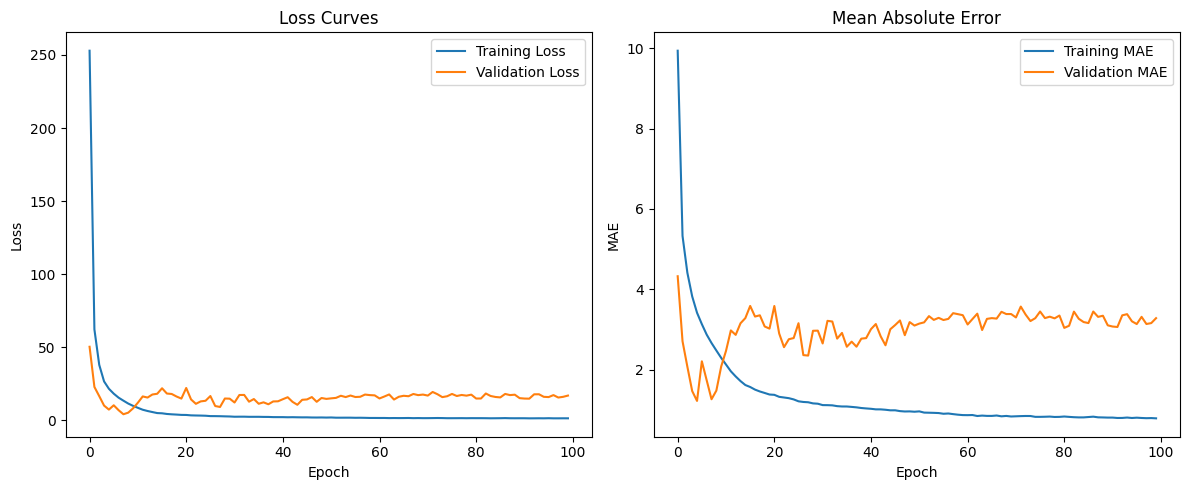

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


 ## Model Evaluation

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Create a DataFrame to compare actual vs predicted values
comparison = pd.DataFrame()
for i, target in enumerate(target_columns):
    comparison[f"{target}_actual"] = y_test[target].values
    comparison[f"{target}_pred"] = y_pred[:, i]

# Display the first few rows of the comparison
comparison.head()


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


,depression_score_actual,depression_score_pred,anxiety_score_actual,anxiety_score_pred,stress_score_actual,stress_score_pred,das_score_actual,das_score_pred
0,31,32.084198,33,31.135813,32,32.337765,58,57.358154
1,46,43.885284,33,31.189579,35,34.767315,68,65.893593
2,22,25.103018,26,26.669809,29,31.501846,46,50.099659
3,54,48.804199,53,46.068447,53,47.669483,96,85.341621
4,19,24.376207,21,23.848017,20,26.217384,36,44.753338


In [17]:
# Evaluate overall model performance
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Overall Test Loss: {loss:.4f}")
print(f"Overall Mean Absolute Error: {mae:.4f}")

# Evaluate performance for each target variable
print("\nDetailed Performance Metrics:")
print("-" * 40)

for i, target in enumerate(target_columns):
    print(f"Results for {target}:")
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)


Overall Test Loss: 17.0490
Overall Mean Absolute Error: 3.2861

Detailed Performance Metrics:
----------------------------------------
Results for depression_score:
  Mean Absolute Error: 2.9742
  R² Score: 0.9138
----------------------------------------
Results for anxiety_score:
  Mean Absolute Error: 2.4708
  R² Score: 0.9143
----------------------------------------
Results for stress_score:
  Mean Absolute Error: 2.9484
  R² Score: 0.8834
----------------------------------------
Results for das_score:
  Mean Absolute Error: 4.7509
  R² Score: 0.8975
----------------------------------------


 ## Visualization: Predictions vs Actuals

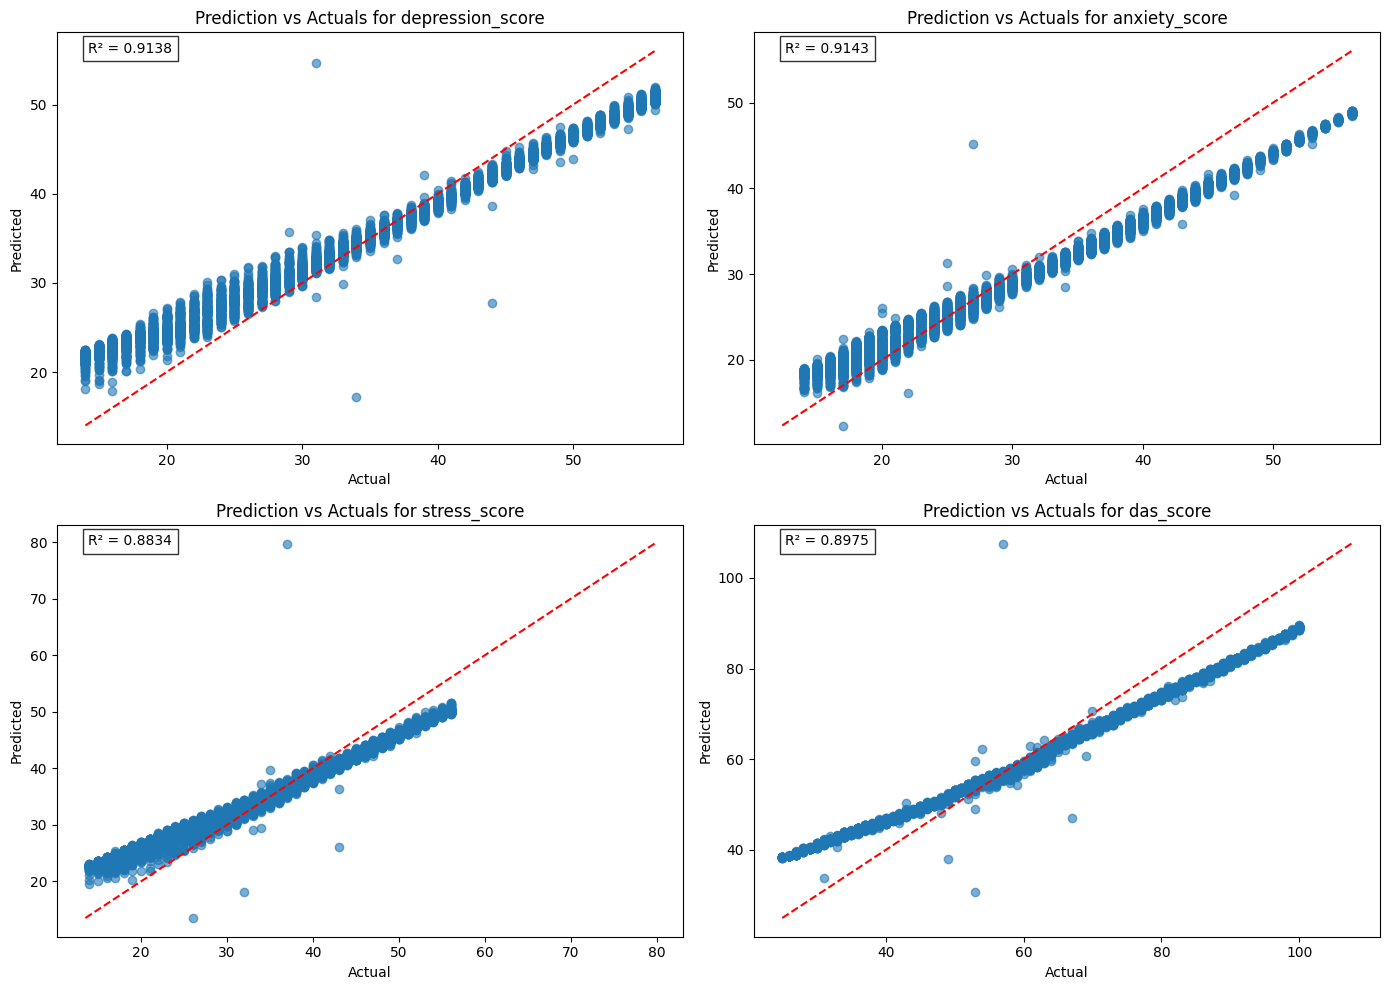

In [18]:
# Plot Predictions vs Actuals for each target
num_targets = len(target_columns)
fig_rows = (num_targets + 1) // 2  # Calculate rows needed for subplots

plt.figure(figsize=(14, 5 * fig_rows))

for i, target in enumerate(target_columns):
    plt.subplot(fig_rows, 2, i + 1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6)

    # Add line of perfect prediction
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")

    plt.title(f"Prediction vs Actuals for {target}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    # Add R² score to the plot
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    plt.text(
        0.05,
        0.95,
        f"R² = {r2:.4f}",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
    )

plt.tight_layout()
plt.show()


 ## Visualization: Residual Plots

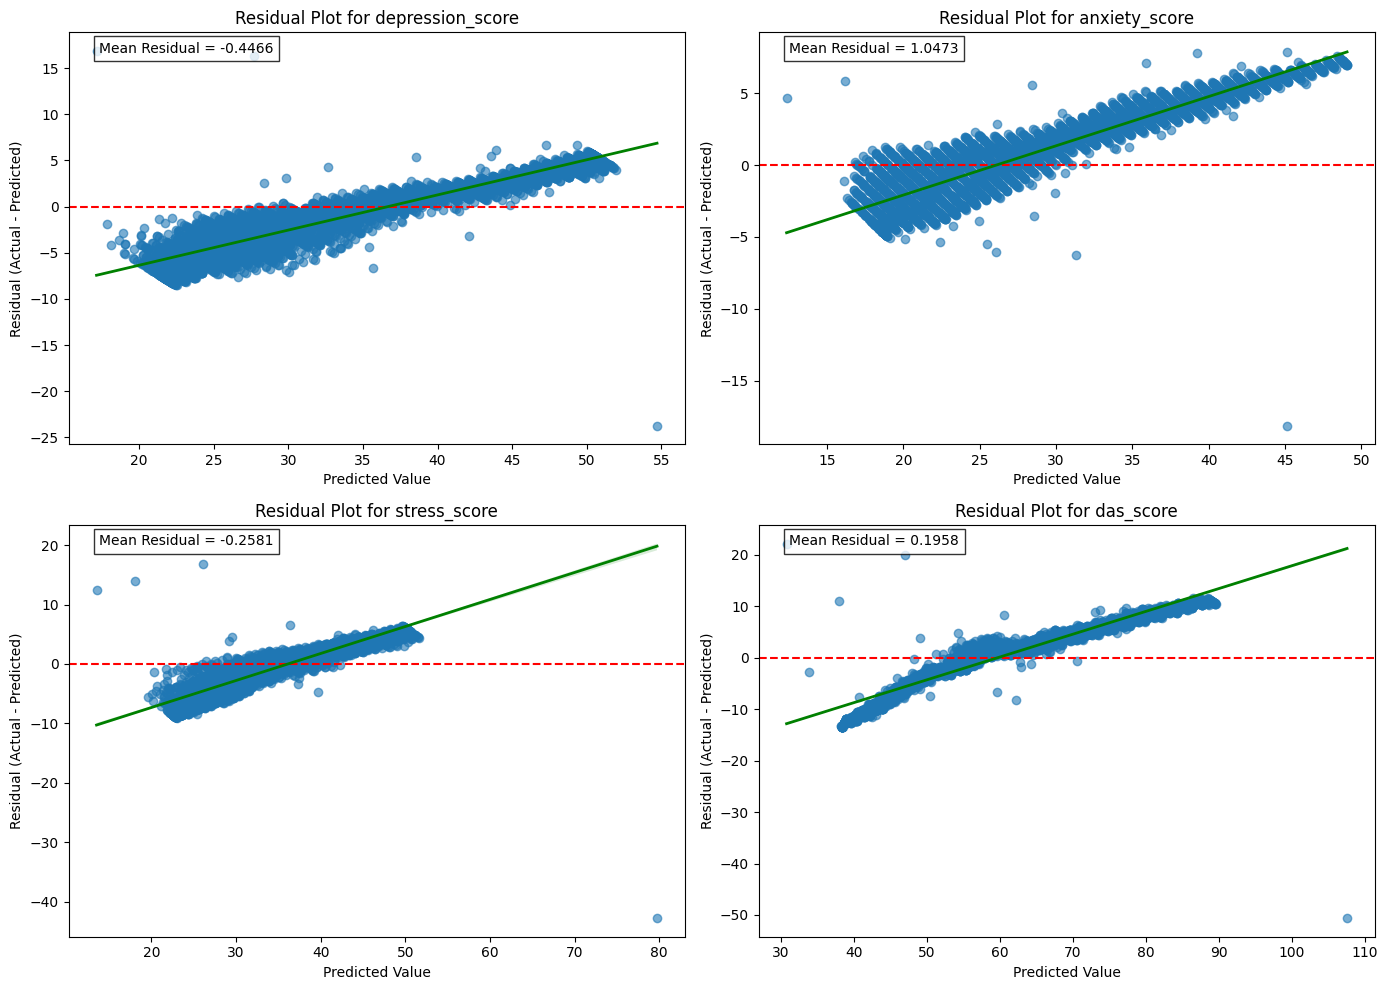

In [ ]:
# Residual plots for each target
plt.figure(figsize=(14, 5 * fig_rows))

for i, target in enumerate(target_columns):
    # Calculate residuals
    residuals = y_test.iloc[:, i] - y_pred[:, i]

    plt.subplot(fig_rows, 2, i + 1)

    # Plot residuals
    plt.scatter(y_pred[:, i], residuals, alpha=0.6)
    plt.axhline(y=0, color="r", linestyle="--")

    # Add regression line to check for bias
    try:
        sns.regplot(
            x=y_pred[:, i],
            y=residuals,
            scatter=False,
            line_kws={"color": "green", "lw": 2},
        )
    except (ValueError, TypeError) as e:
        print(f"Skipping regression line for {target} due to error: {e}")

    plt.title(f"Residual Plot for {target}")
    plt.xlabel("Predicted Value")
    plt.ylabel("Residual (Actual - Predicted)")

    # Add mean of residuals to the plot
    mean_residual = np.mean(residuals)
    plt.text(
        0.05,
        0.95,
        f"Mean Residual = {mean_residual:.4f}",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
    )

plt.tight_layout()
plt.show()


 ## Saving the Model and Preprocessing Information

In [20]:
import joblib

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the trained model using TensorFlow format
model_path = "models/NNv1.keras"
model.save(model_path)

# Save the feature scaler for later use

joblib.dump(scaler, f"{model_path}_scaler.pkl")

# Save feature and target column information
feature_info = {"feature_columns": X.columns.tolist(), "target_columns": target_columns}
joblib.dump(feature_info, f"{model_path}_columns.pkl")

print(f"✅ Model saved to: {model_path}")
print(f"✅ Scaler saved to: {model_path}_scaler.pkl")
print(f"✅ Column information saved to: {model_path}_columns.pkl")


✅ Model saved to: models/NNv1.keras
✅ Scaler saved to: models/NNv1.keras_scaler.pkl
✅ Column information saved to: models/NNv1.keras_columns.pkl


 ## Example: Using the Saved Model for Predictions

In [21]:
# In the load_prediction_model function
from tensorflow.keras.saving import load_model


def load_prediction_model(model_dir="models/neural_network_model.keras"):
    # Load the model with the updated function
    loaded_model = load_model(model_dir)

    # The rest remains the same
    loaded_scaler = joblib.load(f"{model_dir.replace('.keras', '')}_scaler.pkl")
    column_info = joblib.load(f"{model_dir.replace('.keras', '')}_columns.pkl")

    return loaded_model, loaded_scaler, column_info

# Example prediction function
def predict_with_model(input_data, model_dir="models/neural_network_model"):
    # Load model components
    model, scaler, column_info = load_prediction_model(model_dir)

    # Ensure input data has the same features as training data
    feature_cols = column_info["feature_columns"]
    target_cols = column_info["target_columns"]

    # Verify and prepare input data
    if isinstance(input_data, pd.DataFrame):
        # Check if all required features are present
        missing_cols = set(feature_cols) - set(input_data.columns)
        if missing_cols:
            raise ValueError(f"Missing columns in input data: {missing_cols}")

        # Extract and order features to match training order
        input_features = input_data[feature_cols].values
    else:
        # Assume numpy array or list
        input_features = np.array(input_data)
        if input_features.shape[1] != len(feature_cols):
            raise ValueError(
                f"Expected {len(feature_cols)} features, got {input_features.shape[1]}"
            )

    # Scale the input features
    scaled_input = scaler.transform(input_features)

    # Make predictions
    predictions = model.predict(scaled_input)

    # Format predictions as DataFrame with target column names
    pred_df = pd.DataFrame(predictions, columns=target_cols)

    return pred_df


# Example usage (uncomment to test)
# sample_input = X_test.iloc[:5]  # Use first 5 test samples
# predictions = predict_with_model(sample_input)
# print("Sample predictions:")
# print(predictions)
